In [2]:
import time
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib notebook

import tensorflow as tf
print("tensorflow", tf.__version__)

import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar

tensorflow 2.1.0


In [312]:
# =========

# type of lensing operator
lensing_operator = 'interpol'  # 'interpol' or 'simple'

# number of times to subdivide source plane grid
subgrid_res_source = 2

# starlets scales
n_scales_source = 6
n_scales_lens_light = 6

# compute and reduce source plane to minimal size
minimal_source_plane = False

# use the image mask computed through noise threshold
use_threshold_mask = False

# =========

# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF details
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
psf_num_pix_hd = int(np.ceil(psf_num_pix * subgrid_res_source) // 2 * 2 + 1)  # Round up to nearest odd number
psf_kernel_hd = kernel_util.kernel_gaussian(psf_num_pix_hd, delta_pix / subgrid_res_source, psf_fwhm)

# Tensor version
psf_kernel_tf = tf.convert_to_tensor(psf_kernel)

kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)
kwargs_psf_hd = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel_hd}
psf_class_hd = PSF(**kwargs_psf_hd)

# list of lens mass model profiles
lens_model_list = ['SIE'] # ['SPEMD'] not using, since fast4ell is not installed
kwargs_spemd = {'theta_E': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 80, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                  'center_x': 0.1, 'center_y': 0.2}]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [{'amp': 10, 'R_sersic': 2, 'n_sersic': 3, 'e1': -0.2, 'e2': 0.1,
                      'center_x': 0, 'center_y': 0}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("mock lens")
im = plt.imshow(image_sim, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': n_scales_source, 
                          'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

lens_light_model_list_sparsefit = ['STARLETS']
kwargs_starlets_lens_light = {'n_scales': n_scales_lens_light, 
                              'n_pixels': np.size(image_sim)}  # add center_x/center_y
kwargs_lens_light_sparsefit = [kwargs_starlets_lens_light]
lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0, #-0.1,
    'delta_y_source_grid': 0 #0.06
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,  # 'simple' or 'interpol'
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': minimal_source_plane,
    'min_num_pix_source': 69,
    
    'formulation': 'analysis',
    'initial_guess_type': 'noise_map',  # or 'background_rms' for just initializing with gaussian noise
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    #'num_iter': 100,  # when only source
    'num_iter_source': 100,
    'num_iter_lens': 100,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)

grid_offset_x = kwargs_special_sparsefit.get('delta_x_source_grid', 0)
grid_offset_y = kwargs_special_sparsefit.get('delta_y_source_grid', 0)

In [313]:
# we can isolate the solver object
solver = imageSparseFit.sparseSolver

In [319]:
# update manually the lensing operator
start = time.time()
solver.lensingOperator.update_mapping(kwargs_lens)
end = time.time()
print("Lensing operator building took {:e} s".format(end - start))

Lensing operator building took 5.604542e+00 s


In [8]:
def find_surrounding_source_pixels(sourcePlane, i, beta_x, beta_y, grid_offset_x, grid_offset_y,
                                   sort_distance=True):
    # map of the distance to the ray-traced pixel, along each axis, in pixel units
    diff_map_x_pix, diff_map_y_pix = difference_on_source_grid_axis(sourcePlane, i, beta_x, beta_y, 
                                                                    grid_offset_x, grid_offset_y, 
                                                                    pixel_conversion=True)

    # index of source pixel that is the closest to the ray-traced pixel
    j = np.argmin(diff_map_x_pix**2 + diff_map_y_pix**2)

    # find the 4 neighboring pixels
    nb_list, nb_list_2d, idx_closest = neighboring_pixels(sourcePlane, j, diff_map_x_pix, diff_map_y_pix)

    # compute distance (in pixel units) to lower-left "A" neighboring pixel
    dist_to_A_x, dist_to_A_y = distance_lower_left_neighbor(sourcePlane, i, beta_x, beta_y, 
                                                            grid_offset_x, grid_offset_y,
                                                            nb_list, pixel_conversion=True)

    return nb_list, idx_closest, dist_to_A_x, dist_to_A_y
    
def difference_on_source_grid_axis(sourcePlane, i, beta_x_image, beta_y_image, 
                                   grid_offset_x, grid_offset_y,
                                   absolute=False, pixel_conversion=False):
    # coordinate grid of source plane
    theta_x_source = sourcePlane.theta_x + grid_offset_x
    theta_y_source = sourcePlane.theta_y + grid_offset_y
    if pixel_conversion:
        num_pix = sourcePlane.num_pix
        delta_pix = sourcePlane.delta_pix
        theta_x_source = (theta_x_source + delta_pix*num_pix/2.) / delta_pix
        theta_y_source = (theta_y_source + delta_pix*num_pix/2.) / delta_pix
        beta_x_image_i = (beta_x_image[i] + delta_pix*num_pix/2.) / delta_pix
        beta_y_image_i = (beta_y_image[i] + delta_pix*num_pix/2.) / delta_pix
    else:
        beta_x_image_i = beta_x_image[i]
        beta_y_image_i = beta_y_image[i]
    # compute the difference between ray-traced coordinate and source plane grid
    dist_x = beta_x_image_i - theta_x_source
    dist_y = beta_y_image_i - theta_y_source
    if absolute:
        return np.abs(dist_x), np.abs(dist_y)
    return dist_x, dist_y
    
def neighboring_pixels(sourcePlane, j, difference_x, difference_y):
    """
    returns the 4 surrounding pixels in the following order [A, B, C, D]
      C:(0, 1) .____. D:(1, 1)
               | o  |
               |    |
      A:(0, 0) '----' B:(1, 0)

    difference_x, difference_y should be in *pixel units*
    """
    diff_x_j, diff_y_j = difference_x[j], difference_y[j]
    # convert to 2D indices
    r, s = index_1d_to_2d_source(sourcePlane, j)
    if diff_x_j >= 0 and diff_y_j >= 0:
        # closest pixel is A (if the pixel distance to grid is defined as "pixel - coordinates")
        nb_list_2d = [(r, s), (r, s+1), (r+1, s), (r+1, s+1)]
        idx_closest = 0
    elif diff_x_j < 0 and diff_y_j >= 0:
        # closest pixel is B
        nb_list_2d = [(r, s-1), (r, s), (r+1, s-1), (r+1, s)]
        idx_closest = 1
    elif diff_x_j >= 0 and diff_y_j < 0:
        # closest pixel is C
        nb_list_2d = [(r-1, s), (r-1, s+1), (r, s), (r, s+1)]
        idx_closest = 2
    elif diff_x_j < 0 and diff_y_j < 0:
        # closest pixel is D
        nb_list_2d = [(r-1, s-1), (r-1, s), (r, s-1), (r, s)]
        idx_closest = 3
    else:
        raise ValueError("Could not find 4 neighboring pixels for pixel {} ({},{})".format(j, r, s))
    # check if indices are not outside of of the image, put None if it is
    max_index_value = sourcePlane.num_pix - 1
    for idx, (r, s) in enumerate(nb_list_2d):
        if r >= max_index_value or s >= max_index_value:
            nb_list_2d[idx] = (None, None)
    # convert indices to 1D index
    nb_list = [index_2d_to_1d_source(sourcePlane, r, s) for (r, s) in nb_list_2d]
    return nb_list, nb_list_2d, idx_closest

def index_1d_to_2d_source(sourcePlane, j):
    if j is None:
        return (None, None)
    x = int(j / sourcePlane.num_pix)
    y = int(j % sourcePlane.num_pix)
    return (x, y)

def index_2d_to_1d_source(sourcePlane, x, y):
    if x is None or y is None:
        return None
    return y + x * sourcePlane.num_pix
    
def distance_lower_left_neighbor(sourcePlane, i, beta_x, beta_y, grid_offset_x, grid_offset_y, 
                                 neighbor_list, pixel_conversion=False):
    nb_idx_A = 0  # following conventions of neighboring_pixels()
    i_A = neighbor_list[nb_idx_A]
    dist_to_A_x = abs(sourcePlane.theta_x[i_A] + grid_offset_x - beta_x[i])
    dist_to_A_y = abs(sourcePlane.theta_y[i_A] + grid_offset_y - beta_y[i])
    if pixel_conversion:
        dist_to_A_x /= sourcePlane.delta_pix
        dist_to_A_y /= sourcePlane.delta_pix
    return dist_to_A_x, dist_to_A_y

def bilinear_weights(distance_to_A_x, distance_to_A_y):
    """
    returns bilinear weights following order defined in neighboring_pixels()
    similar to Eq. (B2) of Treu & Koopmans 2004
    """
    t, u = distance_to_A_x, distance_to_A_y
    wA = (1. - t) * (1. - u)
    wB = t * (1. - u)
    wC = (1. - t) * u
    wD = t * u
    return [wA, wB, wC, wD]

def check_inside_grid(pixel_list, weight_list):
    """Remove from pixel and weights list."""
    pixel_list_clean, weight_list_clean = [], []
    for p, w in zip(pixel_list, weight_list):
        if p is not None:
            pixel_list_clean.append(p)
            weight_list_clean.append(w)
    return pixel_list_clean, weight_list_clean

# This is essentially _compute_mapping()
def lens_mapping_interpol(lensModel, kwargs_lens, imagePlane, sourcePlane, 
                          grid_offset_x, grid_offset_y, csr_matrix=False):
    lensing_matrix = np.zeros((imagePlane.grid_size, sourcePlane.grid_size))
    beta_x, beta_y = lensModel.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
    for ii in range(imagePlane.grid_size):
        jj, _, dist_A_x, dist_A_y = find_surrounding_source_pixels(sourcePlane, ii, beta_x, beta_y, 
                                                                   grid_offset_x, grid_offset_y)
        weight_list = bilinear_weights(dist_A_x, dist_A_y)
        jj, weight_list = check_inside_grid(jj, weight_list)
        lensing_matrix[ii, jj] = weight_list
    if csr_matrix:
        lensing_matrix = sparse.csr_matrix(lensing_matrix)
    return lensing_matrix

In [315]:
grid_offset_x, grid_offset_y

(0, 0)

<IPython.core.display.Javascript object>


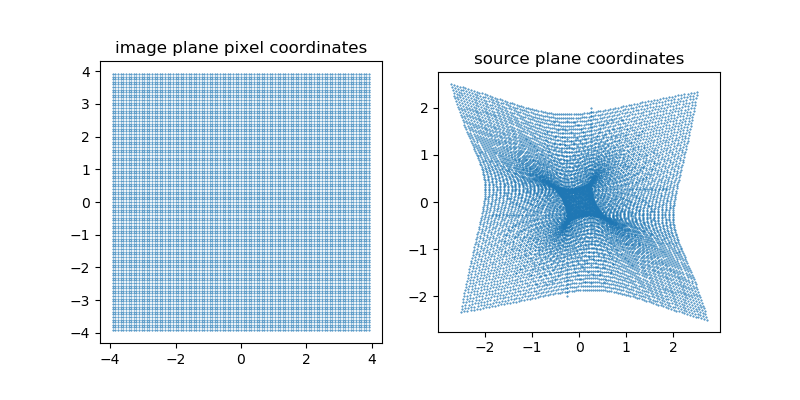

In [316]:
sourcePlane = solver._lensing_op.sourcePlane
imagePlane = solver._lensing_op.imagePlane
lensing_matrix = lens_mapping_interpol(lens_model_class, kwargs_lens, imagePlane, sourcePlane, 
                                       grid_offset_x, grid_offset_y, csr_matrix=True)

beta_x, beta_y = lens_model_class.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(imagePlane.theta_x, imagePlane.theta_y, s=0.2)
axes[0].set_title("image plane pixel coordinates")
axes[1].scatter(beta_x, beta_y, s=0.2)
axes[1].set_title("source plane coordinates")
for ax in axes.flat:
    ax.set_aspect('equal')

In [15]:
%timeit lens_mapping_interpol(lens_model_class, kwargs_lens, imagePlane, sourcePlane, csr_matrix=False)

2.16 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
%timeit lens_mapping_interpol(lens_model_class, kwargs_lens, imagePlane, sourcePlane, csr_matrix=True)

5.69 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [320]:
%timeit solver.lensingOperator.update_mapping(kwargs_lens)

5.56 s ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
ii = np.random.randint(imagePlane.grid_size)
jj, index, dist_A_x, dist_A_y = find_surrounding_source_pixels(sourcePlane, ii, beta_x, beta_y, 
                                                               grid_offset_x, grid_offset_y)
weight_list = bilinear_weights(dist_A_x, dist_A_y)
print(jj)
print(dist_A_x, dist_A_y)
print(weight_list)

[24409, 24410, 24607, 24608]
0.2709722109761948 0.21346709178433346
[0.573404347070931, 0.21312856114473566, 0.15562344195287434, 0.05784364983145914]


In [16]:
find_source_pixels(sourcePlane, beta_x[ii], beta_y[ii], grid_offset_x, grid_offset_y)

(array([[24409, 24410, 24607, 24608]]),
 array([[0.57340435, 0.21312856, 0.15562344, 0.05784365]]))

In [321]:
def find_source_pixels(sourcePlane, beta_x, beta_y, grid_offset_x, grid_offset_y):
    """
    
    Fill this docstring.
    
    """
    # Standardize inputs for vectorization
    beta_x = np.atleast_1d(beta_x)
    beta_y = np.atleast_1d(beta_y)
    
    # Shift source grid if necessary
    source_theta_x = sourcePlane.theta_x + grid_offset_x
    source_theta_y = sourcePlane.theta_y + grid_offset_y
    
    # Compute bin edges so that (theta_x, theta_y) lie at the centers
    half_pix = sourcePlane.delta_pix / 2
    
    theta_x = source_theta_x[:sourcePlane.num_pix]
    xbins = np.linspace(theta_x[0] - half_pix, theta_x[-1] + half_pix, sourcePlane.num_pix + 1)
    index_x = np.digitize(beta_x, xbins) - 1

    theta_y = source_theta_y[::sourcePlane.num_pix]
    ybins = np.linspace(theta_y[0] - half_pix, theta_y[-1] + half_pix, sourcePlane.num_pix + 1)
    index_y = np.digitize(beta_y, ybins) - 1
    
    # Find the (1D) source plane pixel that (beta_x, beta_y) falls in
    index_1 = index_x + index_y * sourcePlane.num_pix
    
    # Compute distances between ray-traced betas and source grid points
    dx = beta_x - source_theta_x[index_1]
    dy = beta_y - source_theta_y[index_1]
    
    # Find the three other nearest pixels
    index_2 = index_1 + np.sign(dx).astype(int)
    index_3 = index_1 + np.sign(dy).astype(int) * sourcePlane.num_pix
    index_4 = index_2 + np.sign(dy).astype(int) * sourcePlane.num_pix
    
    # Gather indices (sorted for correct SparseTensor ordering)
    indices = np.sort([index_1, index_2, index_3, index_4], axis=0).T.flat
    
    # Compute weights like in Treu & Koopmans (2004)
    dist_x = (np.repeat(beta_x, 4) - source_theta_x[indices]) / sourcePlane.delta_pix
    dist_y = (np.repeat(beta_y, 4) - source_theta_y[indices]) / sourcePlane.delta_pix
    weights = (1. - np.abs(dist_x)) * (1. - np.abs(dist_y))
    
    # Construct 2D indices for use in build_lensing_matrix
    indices = (np.repeat(np.arange(imagePlane.grid_size), 4), indices)

    return indices, weights

#     # OLD WAY
#     # Gather indices in [A, B, C, D] order à la Aymeric's code
#     indices = np.sort([index_1, index_2, index_3, index_4], axis=0).T
    
#     # Compute pixel distances to A
#     dist_A_x = np.abs(beta_x - sourcePlane.theta_x[indices[:, 0]] - grid_offset_x) / sourcePlane.delta_pix
#     dist_A_y = np.abs(beta_y - sourcePlane.theta_y[indices[:, 0]] - grid_offset_y) / sourcePlane.delta_pix
    
#     # Compute weights like in Treu & Koopmans (2004)
#     wA = (1. - dist_A_x) * (1. - dist_A_y)
#     wB = dist_A_x * (1. - dist_A_y)
#     wC = (1. - dist_A_x) * dist_A_y
#     wD = dist_A_x * dist_A_y
#     weights = np.array([wA, wB, wC, wD]).T
    
#     return indices, weights

def build_lensing_matrix(lensModel, kwargs_lens, imagePlane, sourcePlane, grid_offset_x, grid_offset_y,
                         sparse_tensor=False):
    # Compute lens mapping from image to source coordinates
    beta_x, beta_y = lensModel.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
    
    # Determine source pixels and their appropriate weights
    indices, weights = find_source_pixels(sourcePlane, beta_x, beta_y, grid_offset_x, grid_offset_y)
    
    # Build lensing matrix either as a sparse tensor or csr matrix
    dense_shape = (imagePlane.grid_size, sourcePlane.grid_size)
    if sparse_tensor:
        lensing_matrix = tf.sparse.SparseTensor(indices=np.column_stack(indices), 
                                                values=weights, dense_shape=dense_shape)
    else:
        lensing_matrix = sparse.csr_matrix((weights, indices), shape=dense_shape)
        
    return lensing_matrix

In [322]:
lm = build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, 
                          grid_offset_x, grid_offset_y, sparse_tensor=True)
if isinstance(lm, tf.sparse.SparseTensor):
    lm = tf.sparse.to_dense(lm).numpy()
if isinstance(lm, sparse.csr_matrix):
    lm = lm.A

In [324]:
np.allclose(lm, lensing_matrix.A), np.allclose(lm, solver._lensing_op._lens_mapping_matrix.A)

(True, True)

In [325]:
%timeit build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, \
                             grid_offset_x, grid_offset_y, sparse_tensor=False)

3.32 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [326]:
%timeit build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, \
                             grid_offset_x, grid_offset_y, sparse_tensor=True)

3.36 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [350]:
csr_lm = build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, 
                              grid_offset_x, grid_offset_y, sparse_tensor=False)
tensor_lm = build_lensing_matrix(lens_model_class, kwargs_lens, imagePlane, sourcePlane, 
                                 grid_offset_x, grid_offset_y, sparse_tensor=True)

In [377]:
s = np.random.randn(198, 198)
s_tf = tf.random.normal(shape=(s.size, 1), dtype=tf.float64)

In [372]:
%timeit csr_lm.dot(s.flatten())

49.2 µs ± 846 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [378]:
%timeit tf.sparse.sparse_dense_matmul(tensor_lm, s_tf)

99.8 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
